In [17]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange
from typing import List

## How to update policies

In [18]:
class PolicyUpdate:
    def update(self, policy, action, reward):
        pass
    def reset(self):
        pass


class SampleAverageUpdate(PolicyUpdate):
    def __init__(self, n_action: int):
        self.n = n_action
        self.action_count = np.zeros(n_action)
    def update(self, policy: "Policy", action: int, reward: float):
        self.action_count[action] += 1
        policy.q_estimation[action] += (reward - policy.q_estimation[action]) / self.action_count[action]
    def reset(self):
        self.action_count = np.zeros(self.n)


class GradientUpdate(PolicyUpdate):
    def __init__(self, n_action: int, gradient_baseline: bool, step_size: float):
        self.n = n_action
        self.gradient_baseline = gradient_baseline
        self.step_size = step_size
        self.average_reward = 0
        self.time = 0

    def update(self, policy: "Policy", action: int, reward: float):
        self.time += 1
        self.average_reward += (reward - self.average_reward) / self.time
        one_hot = np.zeros(self.n)
        one_hot[action] = 1
        if self.gradient_baseline:
            baseline = self.average_reward
        else:
            baseline = 0
        exp_est = np.exp(policy.q_estimation) # not really Q, this would be H in the formula
        action_prob = exp_est / np.sum(exp_est)
        policy.q_estimation += self.step_size * (reward - baseline) * (one_hot - action_prob)
    def reset(self):
        self.average_reward = 0
        self.time = 0

class ConstantUpdate(PolicyUpdate):
    def __init__(self, n_action: int, step_size: float):
        self.n = n_action
        self.step_size = step_size
    def update(self, policy: "Policy", action: int, reward: float):
        policy.q_estimation[action] += self.step_size * (reward - policy.q_estimation[action])
    def reset(self):
        pass


## Policies

In [19]:
class Policy:
    def __init__(self, policy_update: PolicyUpdate, n_actions: int, initial: float):
        self.policy_update = policy_update
        self.n = n_actions
        self.initial = initial
        self.q_estimation = np.zeros(self.n) + self.initial
    def act(self):
        raise NotImplementedError(f"You forgot to implement 'act' in class {self.__class__.__name__}")
    def step(self, action: int, reward: float):
        raise NotImplementedError(f"You forgot to implement 'step' in class {self.__class__.__name__}")
    def reset(self):
        self.q_estimation = np.zeros(self.n) + self.initial
        self.policy_update.reset()

class EpsilonGreedyPolicy(Policy):
    def __init__(self, policy_update: PolicyUpdate, n_actions: int, epsilon: float, initial: float=0.):
        super().__init__(policy_update, n_actions, initial)
        self.epsilon = epsilon
    def act(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, self.n)
        q_best = np.max(self.q_estimation)
        return np.random.choice(np.where(self.q_estimation == q_best)[0])
    def step(self, action: int, reward: float):
        self.policy_update.update(self, action, reward)

class UCBPolicy(Policy):
    def __init__(self, policy_update: PolicyUpdate, n_actions: int, UCB_param: float, initial: float=0):
        super().__init__(policy_update, n_actions, initial)
        self.UCB_param = UCB_param
        self.time = 0
        self.action_count = np.zeros(self.n)
    def act(self):
        UCB_estimation = self.q_estimation + \
                self.UCB_param * np.sqrt(np.log(self.time + 1) / (self.action_count + 1e-5))
        q_best = np.max(UCB_estimation)
        return np.random.choice(np.where(UCB_estimation == q_best)[0])
    def step(self, action: int, reward: float):
        self.time += 1
        self.action_count[action] += 1
        self.policy_update.update(self, action, reward)
    def reset(self):
        super().reset()
        self.action_count = np.zeros(self.n)
        self.time = 0

class GradientPolicy(Policy):
    def __init__(self, policy_update: PolicyUpdate, n_actions: int, initial: float=0):
        super().__init__(policy_update, n_actions, initial)
        self.q_estimation = np.zeros(self.n)
    def act(self):
        exp_est = np.exp(self.q_estimation)
        action_prob = exp_est / np.sum(exp_est)
        return np.random.choice(np.arange(0, self.n), p=action_prob)
    def step(self, action: int, reward: float):
        self.policy_update.update(self, action, reward)

## Environment

In [20]:
class Environment:
    def __init__(self, n_actions, true_reward = 0.):
        self.n = n_actions
        self.true_reward = true_reward
        self.q_true = np.random.randn(self.n) + self.true_reward
        self.best_action = np.argmax(self.q_true)
    def reset(self):
        self.q_true = np.random.randn(self.n) + self.true_reward
        self.best_action = np.argmax(self.q_true)
    def reward(self, action: int):
        return np.random.randn() + self.q_true[action]

## Simulation

In [21]:
K=10
def simulate(runs, time, policies: List[Policy], environment: Environment):
    rewards = np.zeros((len(policies), runs, time))
    best_action_counts = np.zeros(rewards.shape)
    for i, policy in enumerate(policies):
        for r in trange(runs):
            policy.reset()
            environment.reset()
            for t in range(time):
                action = policy.act()
                reward = environment.reward(action)
                policy.step(action, reward)
                rewards[i, r, t] = reward
                if action == environment.best_action:
                    best_action_counts[i, r, t] = 1
    mean_best_action_counts = best_action_counts.mean(axis=1)
    mean_rewards = rewards.mean(axis=1)
    return mean_best_action_counts, mean_rewards

100%|██████████| 2000/2000 [00:18<00:00, 105.86it/s]


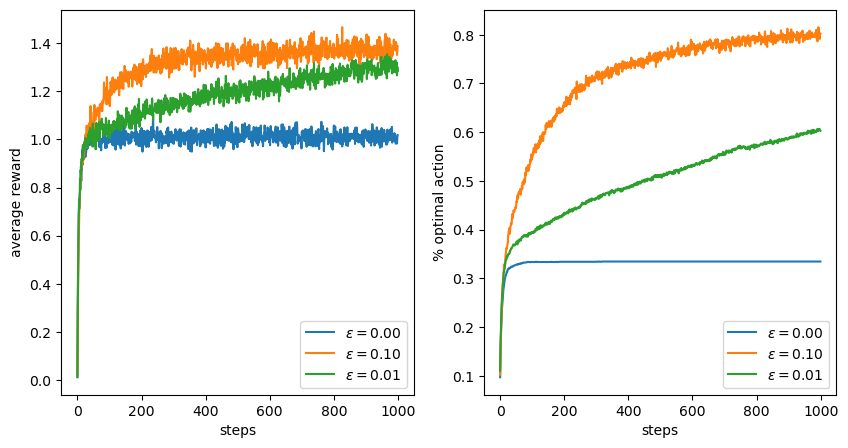

In [24]:
## FIGURE 2.2

runs=2000; time=1000

epsilons = [0, 0.1, 0.01] # bandit = Bandit(epsilon=.9)
bandits = [
    EpsilonGreedyPolicy(SampleAverageUpdate(K), K, 0.),
    EpsilonGreedyPolicy(SampleAverageUpdate(K), K, 0.1),
    EpsilonGreedyPolicy(SampleAverageUpdate(K), K, 0.01),
]
environment = Environment(K)


best_action_counts, rewards = simulate(runs, time, bandits, environment)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
for eps, rewards in zip(epsilons, rewards):
    plt.plot(rewards, label='$\epsilon = %.02f$' % (eps))
plt.xlabel('steps')
plt.ylabel('average reward')
plt.legend()

plt.subplot(1, 2, 2)
for eps, counts in zip(epsilons, best_action_counts):
    plt.plot(counts, label='$\epsilon = %.02f$' % (eps))
plt.xlabel('steps')
plt.ylabel('% optimal action')
plt.legend()

plt.show()

100%|██████████| 2000/2000 [00:17<00:00, 116.57it/s]


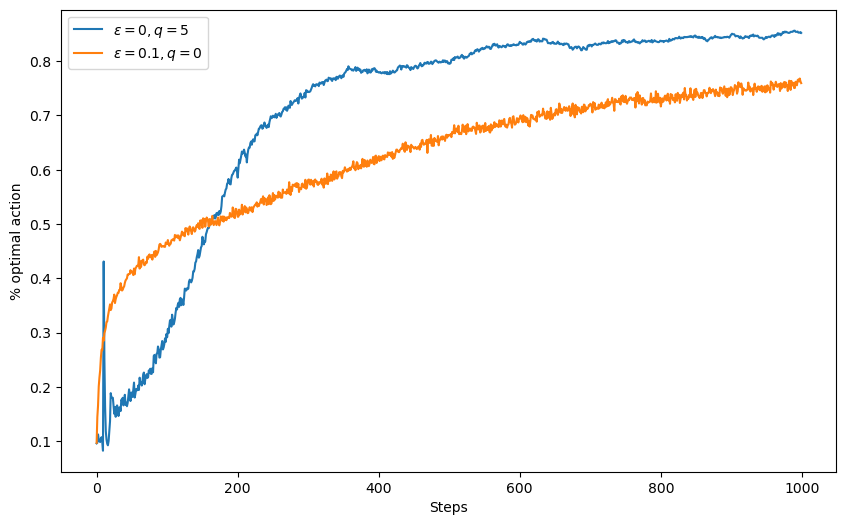

In [25]:
environment = Environment(K)
bandits = [
    EpsilonGreedyPolicy(ConstantUpdate(K, 0.1), K, 0. , initial=5),
    EpsilonGreedyPolicy(ConstantUpdate(K, 0.1), K, 0.1, initial=0),
]
best_action_counts, _ = simulate(runs, time, bandits, environment)

plt.figure(figsize=(10, 6))

plt.plot(best_action_counts[0], label='$\epsilon = 0, q = 5$')
plt.plot(best_action_counts[1], label='$\epsilon = 0.1, q = 0$')
plt.xlabel('Steps')
plt.ylabel('% optimal action')
plt.legend()


plt.show()

100%|██████████| 2000/2000 [00:17<00:00, 112.42it/s]


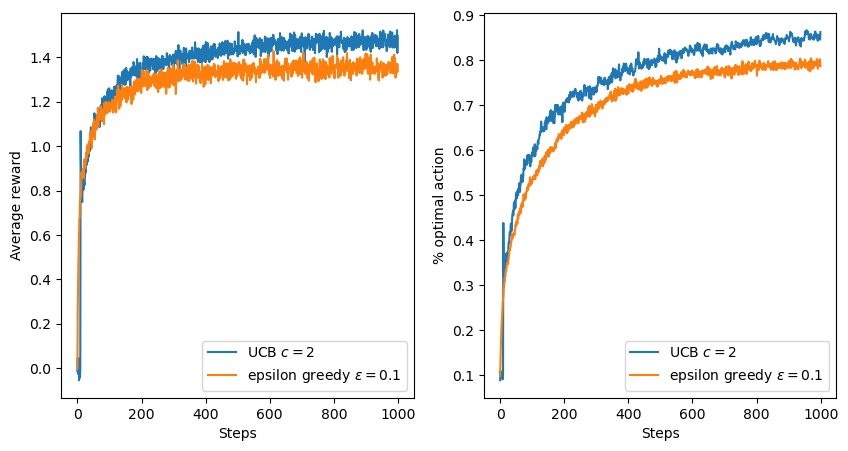

In [26]:
## FIGURE 2.4

environment = Environment(K)
bandits = [
    UCBPolicy(SampleAverageUpdate(K), K, 2),
    EpsilonGreedyPolicy(SampleAverageUpdate(K), K, 0.1)
]
best_action_counts, average_rewards = simulate(runs, time, bandits, environment)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(average_rewards[0], label='UCB $c = 2$')
plt.plot(average_rewards[1], label='epsilon greedy $\epsilon = 0.1$')
plt.xlabel('Steps')
plt.ylabel('Average reward')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(best_action_counts[0], label='UCB $c = 2$')
plt.plot(best_action_counts[1], label='epsilon greedy $\epsilon = 0.1$')
plt.xlabel('Steps')
plt.ylabel('% optimal action')
plt.legend()

plt.show()

100%|██████████| 2000/2000 [00:33<00:00, 59.90it/s]


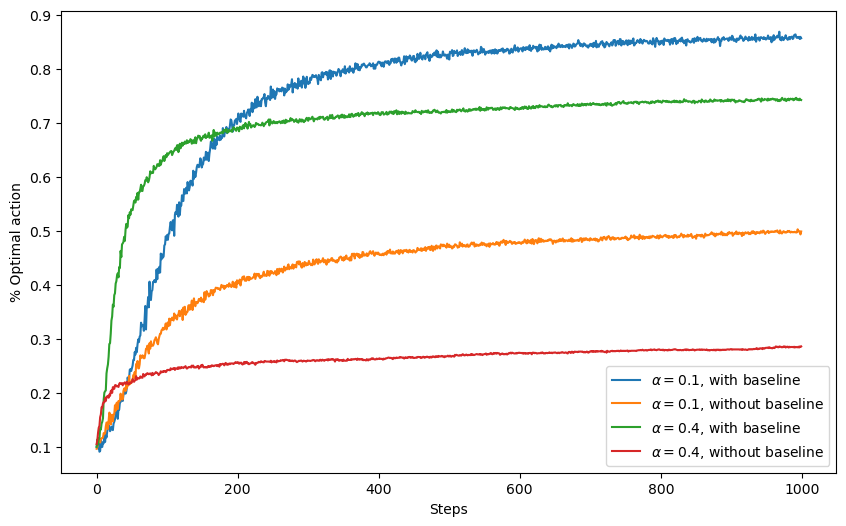

In [27]:
## FIGURE 2.5

bandits = []
environment = Environment(K, true_reward=4)
bandits.append(GradientPolicy(GradientUpdate(K, True, .1), K))
bandits.append(GradientPolicy(GradientUpdate(K, False, .1), K))
bandits.append(GradientPolicy(GradientUpdate(K, True, .4), K))
bandits.append(GradientPolicy(GradientUpdate(K, False, .4), K))
best_action_counts, _ = simulate(runs, time, bandits, environment)
labels = [r'$\alpha = 0.1$, with baseline',
          r'$\alpha = 0.1$, without baseline',
          r'$\alpha = 0.4$, with baseline',
          r'$\alpha = 0.4$, without baseline']

plt.figure(figsize=(10, 6))

for i in range(len(bandits)):
    plt.plot(best_action_counts[i], label=labels[i])
plt.xlabel('Steps')
plt.ylabel('% Optimal action')
plt.legend()

plt.show()

100%|██████████| 2000/2000 [00:19<00:00, 104.35it/s]


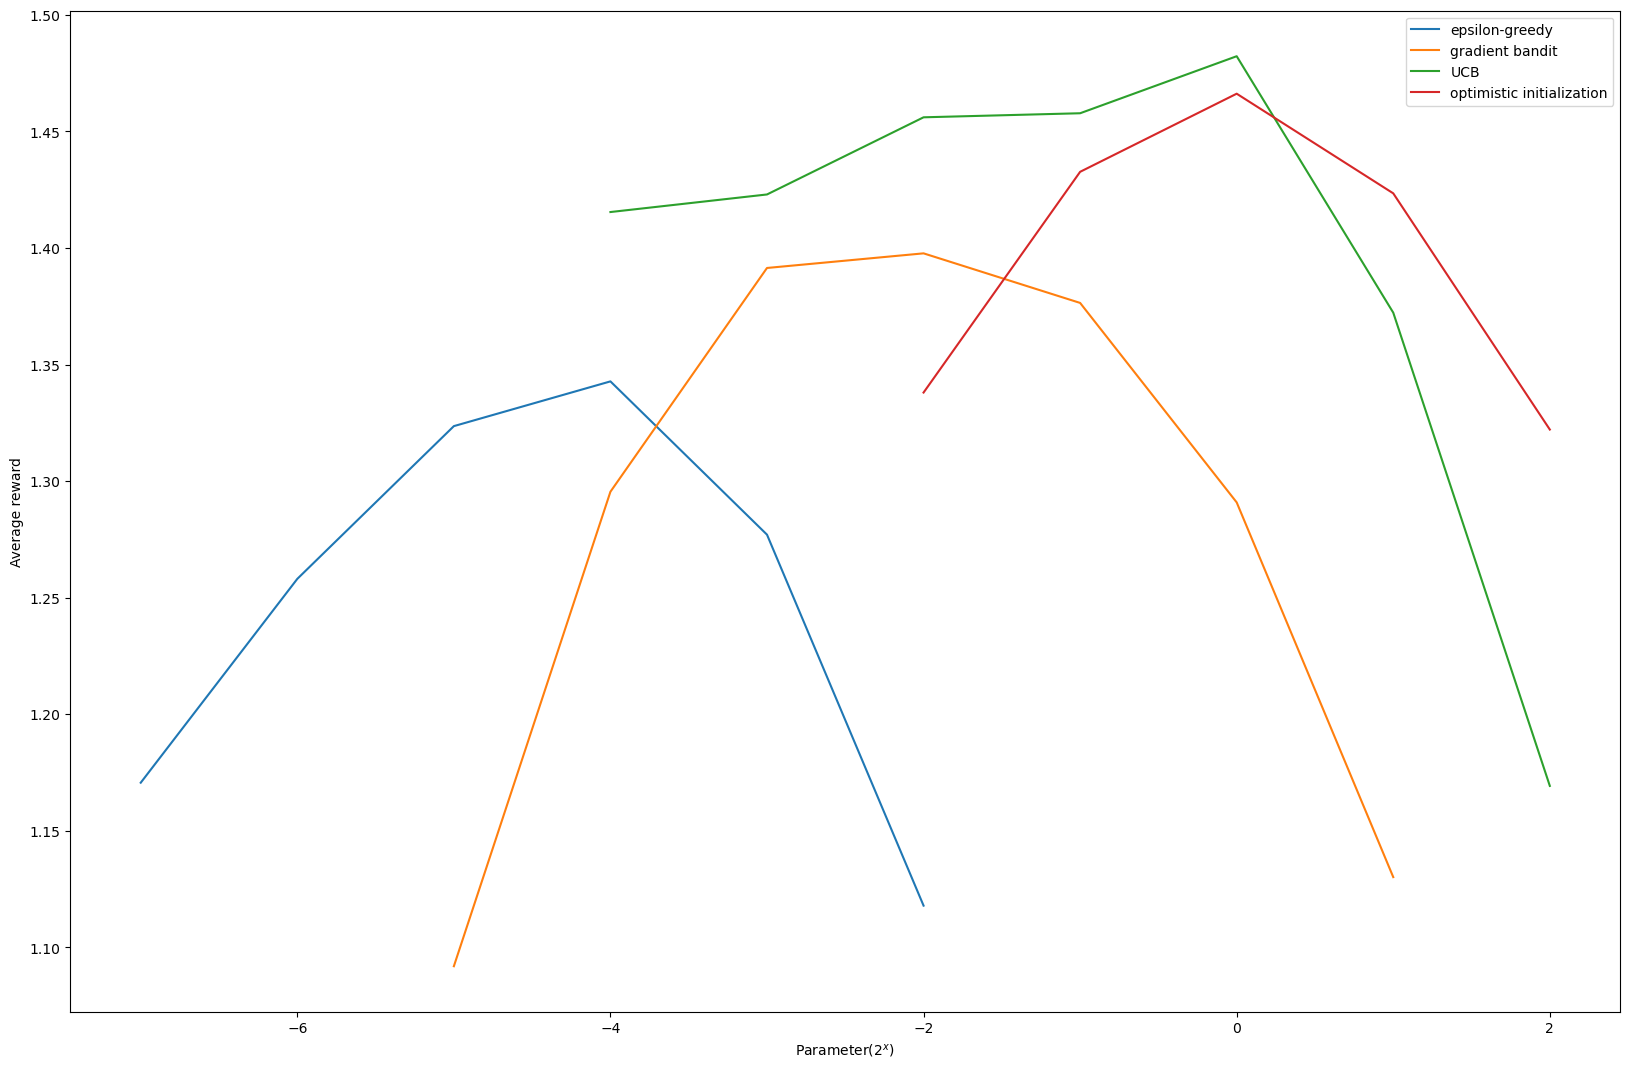

In [28]:
## FIGURE 2.6
labels = ['epsilon-greedy', 'gradient bandit',
          'UCB', 'optimistic initialization']
environment = Environment(K)
generators = [lambda epsilon: EpsilonGreedyPolicy(SampleAverageUpdate(K), K, epsilon),
              lambda alpha: GradientPolicy(GradientUpdate(K, True, alpha), K),
              lambda coef: UCBPolicy(SampleAverageUpdate(K), K, UCB_param=coef),
              lambda initial: EpsilonGreedyPolicy(ConstantUpdate(K, .1), K, 0., initial=initial)]
parameters = [np.arange(-7, -1, dtype=float),
              np.arange(-5, 2, dtype=float),
              np.arange(-4, 3, dtype=float),
              np.arange(-2, 3, dtype=float)]

bandits = []
for generator, parameter in zip(generators, parameters):
    for param in parameter:
        bandits.append(generator(pow(2, param)))

_, average_rewards = simulate(runs, time, bandits, environment)
rewards = np.mean(average_rewards, axis=1)

plt.figure(figsize=(20, 13))

i = 0
for label, parameter in zip(labels, parameters):
    l = len(parameter)
    plt.plot(parameter, rewards[i:i+l], label=label)
    i += l
plt.xlabel('Parameter($2^x$)')
plt.ylabel('Average reward')
plt.legend()

plt.show()

# Exercise

This exercise is meant to be a personal test for you, it's nor mandatory not required of submission, feel free to explore different variants of policies and algorithms.

## Non-stationary Multi-Armed Bandits

In order to complete the following exercise you will have to **modify** the 10-armed testbed environment in such a way that the mean values $q(a)$ of all the arms **start out equal** and then take **independent random walks**. This means that we will have:

$$ q_0(a) = 0, \qquad \forall a \in \mathcal{A}$$

$$q_t(a) = q_{t-1}(a) + w_{t-1}, \qquad \forall a \in \mathcal{A}, \qquad \textrm{where} \quad w_t \sim \mathcal{N}(0, \sigma^2)$$

Assume $\sigma = 0.1$.

Compare the performance of two different instances of the **Epsilon-Greedy algorithm**, one using **sample averages**, and the other using a **constant step size** $\alpha = 0.1$.
Plot the **average reward**, the **cumulative average reward**, and the **average percentage of optimal actions**: use $\epsilon=0.1$ and average over $500 \ \texttt{runs}$ for $5000 \ \texttt{steps}$.

In [ ]:
# TODO